In [1]:
import os 

directory = os.getcwd()

print(directory)

c:\Users\Miguel\Documents\GitHub\Coursework


In [ ]:
import pandas as pd
import numpy as np
import warnings 

ModuleNotFoundError: No module named 'pandas'

In [3]:
warnings.filterwarnings('ignore')


In [4]:
data = pd.read_csv("Transposed_Postive_Regulation_Apoptosis.csv")

In [5]:
x_frame = data.iloc[: , :-1]
#x_frame = x_frame.to_numpy()

y_frame = data.iloc[:,-1:]



In [6]:
from keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D,Reshape
from keras import Input, Model
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn import metrics
from scipy import interp
from tensorflow.keras.optimizers import SGD
from functools import partial
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras import optimizers
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.metrics import f1_score
import shap

In [7]:
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer
le = preprocessing.LabelEncoder()
oe = OrdinalEncoder()
he = OneHotEncoder()
x_frame = oe.fit_transform(x_frame)

y_frame = le.fit_transform(y_frame)


In [16]:
x_train, x_test, y_train, y_test = train_test_split(x_frame, y_frame)

print(x_train)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

[[ 33. 121.   1. ... 114. 158. 127.]
 [ 51. 104.   1. ...  43.  31.  58.]
 [162.   0.   1. ...  68. 122.  40.]
 ...
 [ 88.  72.   1. ... 119.  47.  70.]
 [ 87.  67.   1. ... 128.  96.  93.]
 [121.  40.   1. ... 117.  89. 109.]]
(122,)
(41, 306)
(41,)


In [9]:

#x_train = tf.expand_dims(x_train, axis=-1)


In [10]:
#y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)

In [17]:
print(x_train.shape, y_train.shape)


(122, 306) (122,)


In [20]:
def autoencoder(optimizer ='Adam',learn_rate=0.01, momentum=0):

    autoencoder = Sequential()
    autoencoder.add(Dense(1,  activation='relu', input_shape=(306, )))
    autoencoder.add(Dense(1,  activation='relu'))
    autoencoder.add(Dense(1,  activation='sigmoid'))
    autoencoder.compile(loss='binary_crossentropy', optimizer = 'Adam', metrics=['accuracy'])
    return autoencoder
#autoencoder.summary()
#model.summary()

In [21]:
autoencoder = KerasClassifier(build_fn=autoencoder, verbose=0)

batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(batch_size=batch_size, epochs=epochs,optimizer=optimizer,learn_rate=learn_rate, momentum=momentum)

grid = GridSearchCV(estimator=autoencoder, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.835772 using {'batch_size': 10, 'epochs': 50, 'learn_rate': 0.01, 'momentum': 0.0, 'optimizer': 'Adamax'}
0.819512 (0.042151) with: {'batch_size': 10, 'epochs': 10, 'learn_rate': 0.001, 'momentum': 0.0, 'optimizer': 'SGD'}
0.819512 (0.042151) with: {'batch_size': 10, 'epochs': 10, 'learn_rate': 0.001, 'momentum': 0.0, 'optimizer': 'RMSprop'}
0.819512 (0.042151) with: {'batch_size': 10, 'epochs': 10, 'learn_rate': 0.001, 'momentum': 0.0, 'optimizer': 'Adagrad'}
0.819512 (0.042151) with: {'batch_size': 10, 'epochs': 10, 'learn_rate': 0.001, 'momentum': 0.0, 'optimizer': 'Adadelta'}
0.819512 (0.042151) with: {'batch_size': 10, 'epochs': 10, 'learn_rate': 0.001, 'momentum': 0.0, 'optimizer': 'Adam'}
0.819512 (0.042151) with: {'batch_size': 10, 'epochs': 10, 'learn_rate': 0.001, 'momentum': 0.0, 'optimizer': 'Adamax'}
0.819512 (0.042151) with: {'batch_size': 10, 'epochs': 10, 'learn_rate': 0.001, 'momentum': 0.0, 'optimizer': 'Nadam'}
0.819512 (0.042151) with: {'batch_size': 10, 'ep

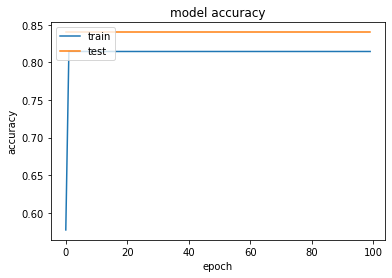

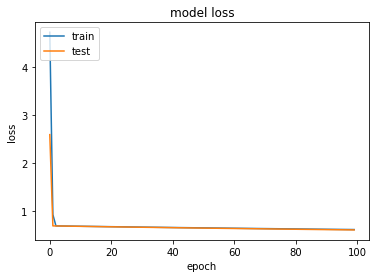

In [22]:
history = autoencoder.fit(x_train, y_train, epochs=100, batch_size=40, validation_split=0.2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
# Determines the f-score of the model using a new tenth split. 

autoencoder.fit(x_train,y_train)
yhat=autoencoder.predict(x_test)
f1score=f1_score(yhat,y_test, average ='weighted')
print(f1score)

0.8918918918918918


[1 1 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0
 1 1 1 1]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


[]

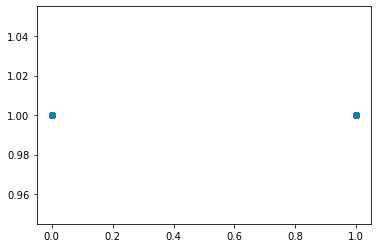

In [24]:
from itertools import chain
predictions = autoencoder.predict(x_test)
test_predictions = []
for l in predictions: 
    for item in l:
        test_predictions.append(item)
test_predictions = np.array(test_predictions)
#test_predictions = (list(chain(*test_predictions)))
print(y_test)
print(type(y_test))
print(type(test_predictions))
print(test_predictions)
plt.scatter(y_test, test_predictions)
plt.plot()

In [ ]:
#Perform Shap analysis on the predictiors of the data for the class = 0, as it the model balances itself to the final prediction.
#Each predictor either increase (red) or decreases(blue) the prediction score. 
shap.initjs()
explainer = shap.DeepExplainer(autoencoder,x_train)
print(type(explainer))
shap_values = explainer.shap_values(x_test[0:,])

shap.force_plot(explainer.expected_value, shap_values[0], x_test[0,:])


In [ ]:
#Perform Shap analysis on the predictiors of the data for the class = 0, as it the model balances itself to the final prediction.
#Each predictor either increase (red) or decreases(blue) the prediction score. 
shap.initjs()
explainer = shap.DeepExplainer(autoencoder.predict,x_train)
shap_values = explainer.shap_values(x_test[0:,])
shap.force_plot(explainer.expected_value, shap_values[1], x_test[0,:])

In [ ]:
#This code produces a beeswarm plot showing the impact of the top 10 features on the model when its value is 0.
#creates the explainer object
explainer = shap.DeepExplainer(autoencoder)
#produces values from the test set. 
shap_values = explainer.shap_values(x_test)
#creates the shap object for the plot
shap_object = explainer(x_test)
#produces the plot
shap.summary_plot(shap_values[0],x_test)


In [ ]:
#This code produces a beeswarm plot showing the impact of the top 10 features on the model when its value is 1.
#creates the explainer object
explainer = shap.DeepExplainer(autoencoder)
#produces values from the test set. 
shap_values = explainer.shap_values(x_test)
#creates the shap object for the plot
shap_object = explainer(x_test)
#produces the plot
shap.summary_plot(shap_values[1],x_test)

In [ ]:
#Uses the learning curve function from the yellowbrick library to identify if the model could benefit from more training samples. 
from yellowbrick.model_selection import learning_curve
#prints the learning curve plot. 
print(learning_curve(autoencoder,x_test, y_test,cv=10,))

In [ ]:
data2 =  pd.read_csv("Transposed_transport_genes.csv")

In [ ]:
x_frame2 = data2.iloc[: , :-1]
#x_frame = x_frame.to_numpy()

y_frame2 = data2.iloc[:,-1:]



In [ ]:
x_frame2 = oe.fit_transform(x_frame2)

y_frame2 = le.fit_transform(y_frame2)

In [ ]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x_frame2,y_frame2)
print(x_train2)
print(y_train2.shape)
print(x_test2.shape)
print(y_test2.shape)

In [ ]:
def autoencoder2(optimizer ='Adam',learn_rate=0.01, momentum=0):
    
    autoencoder2 = Sequential()
    autoencoder2.add(Dense(1,  activation='relu', input_shape=(355, 1)))
    autoencoder2.add(Dense(5,  activation='relu'))
    autoencoder2.add(Dense(5,   activation='sigmoid', name="bottleneck"))
    autoencoder2.add(Dense(1,  ))
    autoencoder2.add(Dense(1,  activation='sigmoid'))
    autoencoder2.add(Flatten())
    autoencoder2.add(Dense(1,  activation='sigmoid'))
    autoencoder2.compile(loss='MSE', optimizer = Adam())
    return autoencoder2

In [ ]:
autoencoder2 = KerasClassifier(build_fn=autoencoder2, verbose=0)

batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(batch_size=batch_size, epochs=epochs,optimizer=optimizer,learn_rate=learn_rate, momentum=momentum)

grid = GridSearchCV(estimator=autoencoder2, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train2, y_train2)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
history = autoencoder2.fit(x_train2, y_train2, epochs=40, batch_size=100, validation_split=0.2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Determines the f-score of the model using a new tenth split. 


autoencoder2.fit(x_train2,y_train2)
yhat2=autoencoder2.predict(x_test2)
f1score2=f1_score(yhat2,y_test2, average ='weighted')
print(f1score2)

In [ ]:
from itertools import chain
predictions2 = autoencoder2.predict(x_test2)
test_predictions2 = []
for l in predictions2: 
    for item in l:
        test_predictions2.append(item)
test_predictions2 = np.array(test_predictions2)
#test_predictions = (list(chain(*test_predictions)))
print(y_test2)
print(type(y_test2))
print(type(test_predictions2))
print(test_predictions2)
plt.scatter(y_test2, test_predictions2)
plt.plot()

In [ ]:
#Perform Shap analysis on the predictiors of the data for the class = 0, as it the model balances itself to the final prediction.
#Each predictor either increase (red) or decreases(blue) the prediction score. 
shap.initjs()
explainer = shap.KernelExplainer(autoencoder2.predict,x_train2)
print(type(explainer2))
shap_values = explainer.shap_values(x_test2[0:,])

shap.force_plot(explainer.expected_value, shap_values[0], x_test2[0,:])




In [ ]:
#Perform Shap analysis on the predictiors of the data for the class = 0, as it the model balances itself to the final prediction.
#Each predictor either increase (red) or decreases(blue) the prediction score. 
shap.initjs()
explainer = shap.KernelExplainer(autoencoder2.predict,x_train)
shap_values = explainer.shap_values(x_test[0:,])
shap.force_plot(explainer.expected_value, shap_values[1], x_test[0,:])

In [ ]:
#This code produces a beeswarm plot showing the impact of the top 10 features on the model when its value is 0.
#creates the explainer object
explainer = shap.TreeExplainer(cautoencoder2)
#produces values from the test set. 
shap_values = explainer.shap_values(x_test2)
#creates the shap object for the plot
shap_object = explainer(x_test2)
#produces the plot
shap.summary_plot(shap_values2[0],x_test2)


In [ ]:
#This code produces a beeswarm plot showing the impact of the top 10 features on the model when its value is 1.
#creates the explainer object
explainer = shap.TreeExplainer(autoencoder2)
#produces values from the test set. 
shap_values = explainer.shap_values(x_test2)
#creates the shap object for the plot
shap_object = explainer(x_test2)
#produces the plot
shap.summary_plot(shap_values[1],x_test2)

In [ ]:
#Uses the learning curve function from the yellowbrick library to identify if the model could benefit from more training samples. 
from yellowbrick.model_selection import learning_curve
#prints the learning curve plot. 
print(learning_curve(autoencoder2,x_test2, y_test2,cv=10,))